In [1]:
#imports
from preprocessing import prepare_dataset
from engine import model_eval
import helper_functions

/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

## 0. Preprocessing

In [2]:
X_template, y_template = prepare_dataset(data_dir="data/",
                                      features="Standard")

In [3]:
X_improved, y_improved = prepare_dataset(data_dir="data/",
                                      features="Improved")

## 1. Model Investigation

### 1.1 Template model

In [ ]:
template_model = model_eval(X = X_template, y = y_template, model_type = "OLS")

### 1.2 Ridge regression model

In [ ]:
Ridge_model = model_eval(X = X_improved, y = y_improved, model_type = "Ridge")

### 1.3 XGboost

In [ ]:
xgboost_model = model_eval(X = X_improved, y = y_improved, model_type = "XGboost")

### 1.4 NN default topics

Model Training:   0%|          | 0/1200 [00:00<?, ?it/s]

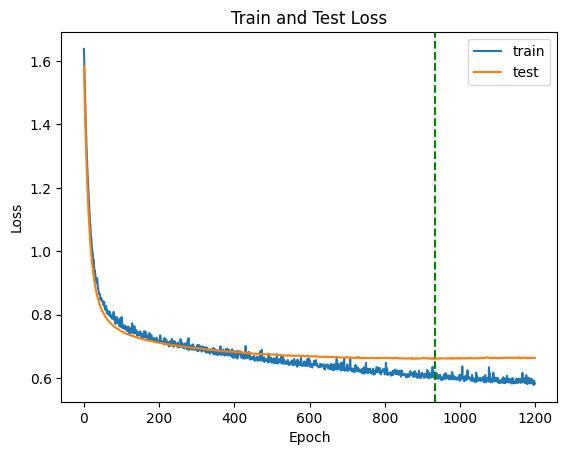

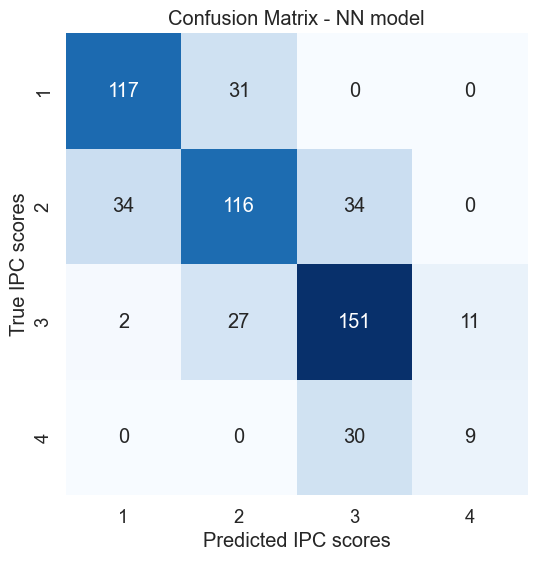

Mean Absolute Error (MAE): 0.304270462633452
Accuracy: 0.699288256227758
F1 Score: 0.6908699262978013


In [4]:
NN_default_model, default_true_labels, default_predicted_probabilities, default_predicted_labels = model_eval(X = X_template,
                                                                                                              y = y_template,
                                                                                                              model_type = "NN")

### 1.5 Final NN

Model Training:   0%|          | 0/1200 [00:00<?, ?it/s]

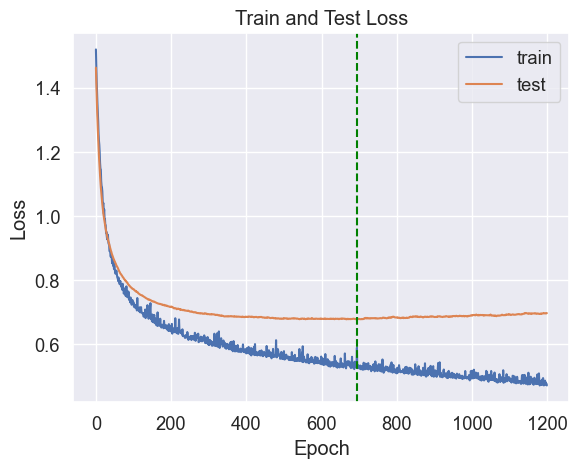

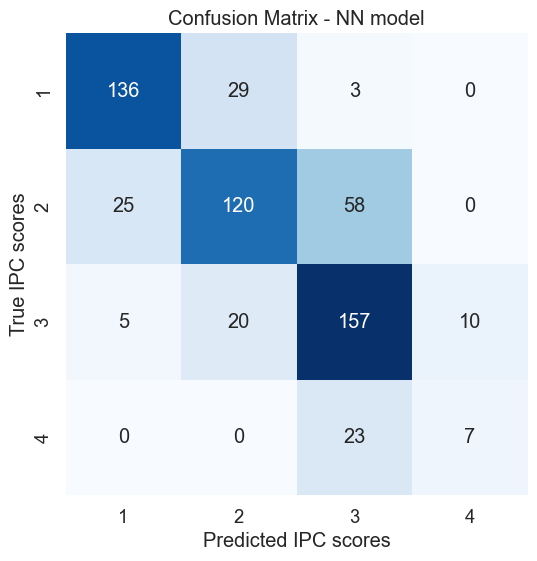

Mean Absolute Error (MAE): 0.30522765598650925
Accuracy: 0.7082630691399663
F1 Score: 0.7014359860991132


In [5]:
NN_final_model, final_true_labels, final_predicted_probabilities, final_predicted_labels  = model_eval(X = X_improved,
                                                                                                       y = y_improved,
                                                                                                       model_type = "NN")

## 2. Article Utilization

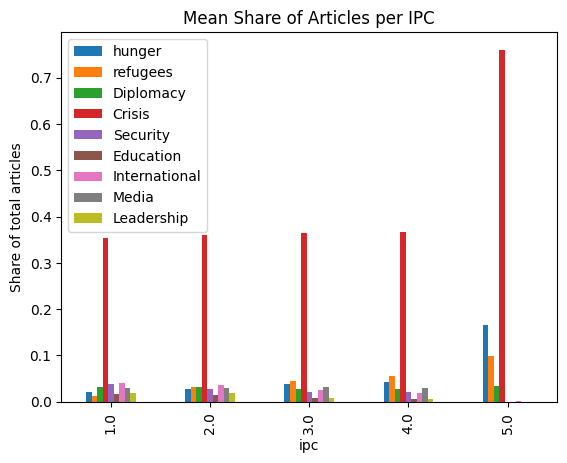

In [3]:
helper_functions.articles_per_ipc(y_template)

Preparing data for the Pie Chart:   0%|          | 0/18520 [00:00<?, ?it/s]

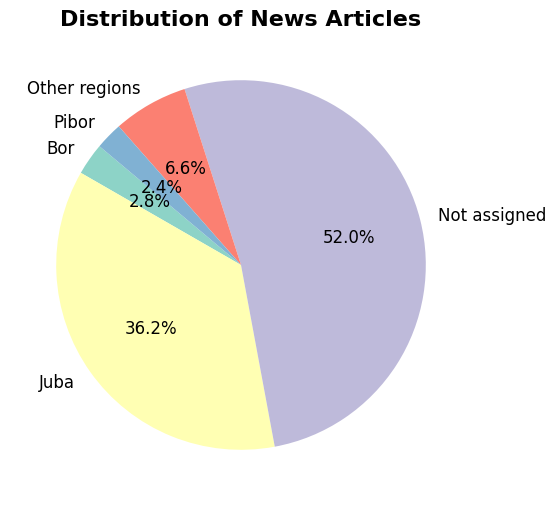

In [3]:
helper_functions.articles_per_region()

## 3. Bias Reduction